In [1]:
import matplotlib.pyplot as plt
from DataReader import load_data, train_vaild_split
from Model import Cifar
import os
import torch
import numpy as np
from NetWork import ResNet, resnet18
from ImageUtils import parse_record
from tqdm import tqdm

def run_experiment(batch_size, save_interval, weight_decay, learning_rate, modeldir, use_residual, use_bn, device, epochs=100):
    class Config:
        def __init__(self):
            self.batch_size = batch_size
            self.save_interval = save_interval
            self.weight_decay = weight_decay
            self.lr = learning_rate
            self.modeldir = modeldir
            self.use_residual = use_residual
            self.use_bn = use_bn
            self.device = device
    
    config = Config()
    
    # Load and split data
    data_dir = "dataset/cifar-10-batches-py"
    x_train, y_train, x_test, y_test = load_data(data_dir)
    x_train_new, y_train_new, x_valid, y_valid = train_vaild_split(x_train, y_train)

    # Initialize and train the model
    model = Cifar(config).to(device)
    print(f"\n--- Training with learning rate {learning_rate}, Residual: {use_residual}, BatchNorm: {use_bn} ---")

    # Track losses
    training_losses = []
    testing_losses = []

    for epoch in range(1, epochs + 1):
        # Training
        model.network.train()
        epoch_loss = 0
        for i in range(0, len(x_train_new), config.batch_size):

            batch_x = np.array([parse_record(record, training=True) for record in x_train_new[i:i + config.batch_size]])
            batch_y = y_train_new[i:i + config.batch_size]
        
            batch_x = torch.tensor(batch_x, dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.long).to(device)
            model.optimizer.zero_grad()
            logits = model.network(batch_x)
            loss = model.loss_fn(logits, batch_y)
            loss.backward()
            model.optimizer.step()
            epoch_loss += loss.item()

        avg_training_loss = epoch_loss / (len(x_train_new) // config.batch_size)
        training_losses.append(avg_training_loss)
        print(f"Epoch {epoch}/{epochs}, Training Loss: {avg_training_loss:.4f}")

        # Testing loss every 10 epochs
        if epoch % 10 == 0:
            model.network.eval()
            with torch.no_grad():
                test_loss = 0
                for i in range(0, len(x_test), config.batch_size):
                    batch_x = np.array([parse_record(record, training=False) for record in x_test[i:i + config.batch_size]])
                    batch_y = y_test[i:i + config.batch_size]

                    batch_x = torch.tensor(batch_x, dtype=torch.float32).to(device)
                    batch_y = torch.tensor(batch_y, dtype=torch.long).to(device)
                    logits = model.network(batch_x)
                    loss = model.loss_fn(logits, batch_y)
                    test_loss += loss.item()
                avg_testing_loss = test_loss / (len(x_test) // config.batch_size)
                testing_losses.append(avg_testing_loss)
                print(f"Epoch {epoch}/{epochs}, Testing Loss: {avg_testing_loss:.4f}")

        model.scheduler.step()

    # Final testing accuracy
    model.network.eval()
    preds = []
    with torch.no_grad():
        for i in tqdm(range(x_test.shape[0])):
            record = parse_record(x_test[i], training=False)
            record = torch.tensor(record, dtype=torch.float32).unsqueeze(0).to(config.device)

            logits = model.network(record)
            pred = torch.argmax(logits, dim=1).item()
            preds.append(pred)

    y_tensor = torch.tensor(y_test, dtype=torch.long).to(config.device)
    preds_tensor = torch.tensor(preds, dtype=torch.long).to(config.device)
    final_accuracy = torch.sum(preds_tensor == y_tensor).item() / y_tensor.size(0)

    print(f"\nFinal Testing Accuracy: {final_accuracy:.4f}")

    # Plot training and testing loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), training_losses, label="Training Loss")
    plt.plot(range(10, epochs + 1, 10), testing_losses, label="Testing Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves - Residual: {use_residual}, BatchNorm: {use_bn}")
    plt.legend()
    plt.show()


--- Training with learning rate 0.003, Residual: True, BatchNorm: False ---
Epoch 1/100, Training Loss: 1.7205
Epoch 2/100, Training Loss: 1.2948
Epoch 3/100, Training Loss: 1.1171
Epoch 4/100, Training Loss: 1.0126
Epoch 5/100, Training Loss: 0.9375
Epoch 6/100, Training Loss: 0.8885
Epoch 7/100, Training Loss: 0.8488
Epoch 8/100, Training Loss: 0.8125
Epoch 9/100, Training Loss: 0.7870
Epoch 10/100, Training Loss: 0.7631
Epoch 10/100, Testing Loss: 0.8776
Epoch 11/100, Training Loss: 0.6798
Epoch 12/100, Training Loss: 0.6621
Epoch 13/100, Training Loss: 0.6424
Epoch 14/100, Training Loss: 0.6308
Epoch 15/100, Training Loss: 0.6155
Epoch 16/100, Training Loss: 0.6057
Epoch 17/100, Training Loss: 0.5979
Epoch 18/100, Training Loss: 0.5868
Epoch 19/100, Training Loss: 0.5741
Epoch 20/100, Training Loss: 0.5670
Epoch 20/100, Testing Loss: 0.7100
Epoch 21/100, Training Loss: 0.5147
Epoch 22/100, Training Loss: 0.4967
Epoch 23/100, Training Loss: 0.4863
Epoch 24/100, Training Loss: 0.480

100%|██████████| 10000/10000 [00:11<00:00, 884.22it/s]



Final Testing Accuracy: 0.8301


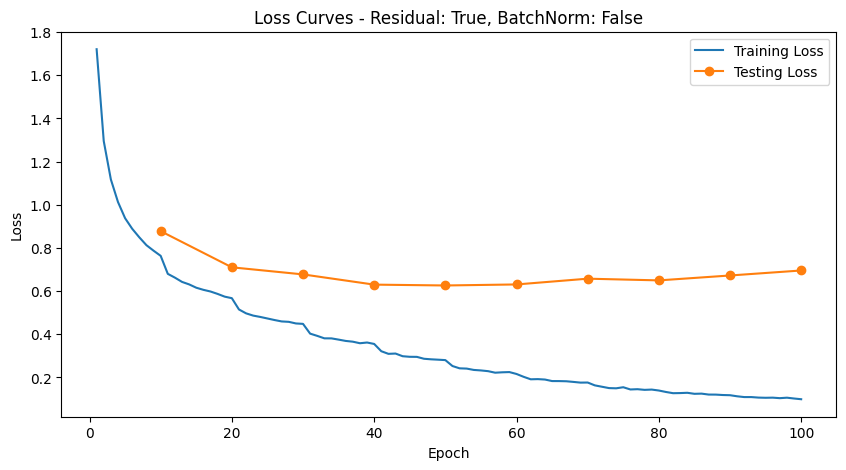


--- Training with learning rate 0.003, Residual: False, BatchNorm: True ---
Epoch 1/100, Training Loss: 1.7346
Epoch 2/100, Training Loss: 1.3290
Epoch 3/100, Training Loss: 1.1419
Epoch 4/100, Training Loss: 1.0241
Epoch 5/100, Training Loss: 0.9527
Epoch 6/100, Training Loss: 0.8951
Epoch 7/100, Training Loss: 0.8487
Epoch 8/100, Training Loss: 0.8157
Epoch 9/100, Training Loss: 0.7847
Epoch 10/100, Training Loss: 0.7645
Epoch 10/100, Testing Loss: 0.9727
Epoch 11/100, Training Loss: 0.6798
Epoch 12/100, Training Loss: 0.6583
Epoch 13/100, Training Loss: 0.6450
Epoch 14/100, Training Loss: 0.6293
Epoch 15/100, Training Loss: 0.6178
Epoch 16/100, Training Loss: 0.6055
Epoch 17/100, Training Loss: 0.5943
Epoch 18/100, Training Loss: 0.5869
Epoch 19/100, Training Loss: 0.5783
Epoch 20/100, Training Loss: 0.5658
Epoch 20/100, Testing Loss: 0.7676
Epoch 21/100, Training Loss: 0.5107
Epoch 22/100, Training Loss: 0.5036
Epoch 23/100, Training Loss: 0.4920
Epoch 24/100, Training Loss: 0.480

100%|██████████| 10000/10000 [00:11<00:00, 882.40it/s]



Final Testing Accuracy: 0.8289


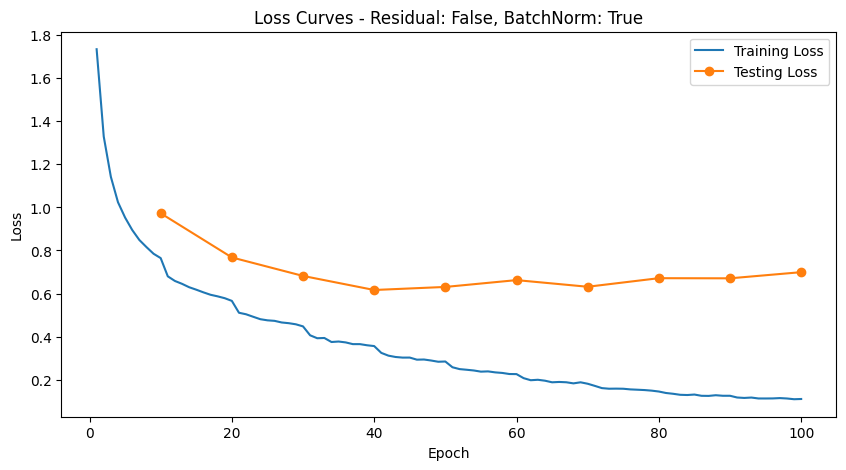


--- Training with learning rate 0.003, Residual: True, BatchNorm: True ---
Epoch 1/100, Training Loss: 1.7407
Epoch 2/100, Training Loss: 1.3147
Epoch 3/100, Training Loss: 1.1404
Epoch 4/100, Training Loss: 1.0237
Epoch 5/100, Training Loss: 0.9519
Epoch 6/100, Training Loss: 0.8945
Epoch 7/100, Training Loss: 0.8541
Epoch 8/100, Training Loss: 0.8189
Epoch 9/100, Training Loss: 0.7834
Epoch 10/100, Training Loss: 0.7571
Epoch 10/100, Testing Loss: 0.9972
Epoch 11/100, Training Loss: 0.6784
Epoch 12/100, Training Loss: 0.6548
Epoch 13/100, Training Loss: 0.6459
Epoch 14/100, Training Loss: 0.6248
Epoch 15/100, Training Loss: 0.6152
Epoch 16/100, Training Loss: 0.6038
Epoch 17/100, Training Loss: 0.5926
Epoch 18/100, Training Loss: 0.5811
Epoch 19/100, Training Loss: 0.5759
Epoch 20/100, Training Loss: 0.5677
Epoch 20/100, Testing Loss: 0.7359
Epoch 21/100, Training Loss: 0.5128
Epoch 22/100, Training Loss: 0.4972
Epoch 23/100, Training Loss: 0.4912
Epoch 24/100, Training Loss: 0.4794

100%|██████████| 10000/10000 [00:12<00:00, 833.07it/s]



Final Testing Accuracy: 0.8309


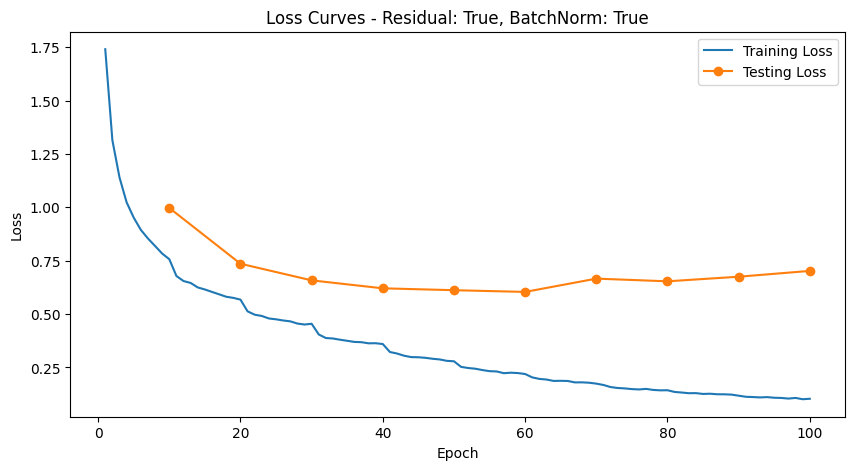

In [2]:
# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory for saving models
MODEL_DIR = "best-models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Define configurations for ResNet variations
configs = [
    {"use_residual": True, "use_bn": False, "modeldir": os.path.join(MODEL_DIR, "resnet18_no_bn")},
    {"use_residual": False, "use_bn": True, "modeldir": os.path.join(MODEL_DIR, "resnet18_no_residual")},
    {"use_residual": True, "use_bn": True, "modeldir": os.path.join(MODEL_DIR, "resnet18")},
]

# Run experiments for each configuration and learning rate
for config in configs:
    run_experiment(
        batch_size=128,
        save_interval=10,
        weight_decay=2e-4,
        learning_rate=0.003,
        modeldir=config["modeldir"],
        use_residual=config["use_residual"],
        use_bn=config["use_bn"],
        device=device
    )
